In [1]:
import torch
import random
i = random.randint(1,200)
input_file_path = f'/projectnb/textconv/llama/generated_datasets/negativeten_ten/input{i}.pt'
target_file_path = f'/projectnb/textconv/llama/generated_datasets/negativeten_ten/target{i}.pt'
# Load the tensors from the .pt file
input_tensor = torch.load(input_file_path, map_location='cpu')
target_tensor = torch.load(target_file_path, map_location='cpu')
# Now you can work with the loaded tensors
# For example, you can print them or perform operations on them
print(input_tensor.shape,target_tensor.shape )

torch.Size([100, 512, 32000]) torch.Size([100, 32000])


In [2]:
input_tensor,target_tensor

(tensor([[[-8.6016, -8.8047,  5.3477,  ...,  4.2734, -5.0352, -2.9629],
          [-3.7871, -2.7109,  0.9404,  ...,  5.0234, -8.1875,  1.2168],
          [-7.5078,  3.8965,  4.4453,  ..., -0.4949,  9.3750,  2.6172],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 8.1250, -5.8945, -1.4502,  ..., -6.6953,  6.7422, -4.3633],
          [ 7.4570,  8.8984,  5.6719,  ...,  7.9219, -7.0352,  0.3359],
          [-8.7188, -0.7969,  5.2266,  ..., -4.0977, -6.3203,  3.2500],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-1.0176,  1.1416,  7.2148,  ..., -9.3281,  8.8906,  7.6250],
          [-3.0898,  5.3945,

In [4]:
torch.argmax(target_tensor, axis = -1) #okay, negativeten_ten is looking like good data.  

tensor([13364, 25434, 30189, 30488, 18656,  2153,  9425, 22328,  9026, 13025,
         1647, 28898, 24532, 15321, 12309, 19324, 26178, 11248,  1647, 13111,
         1210, 15958,  6086, 19682, 11890, 14095,   224, 20728,  7489, 27918,
        18505,  6202,  4316, 15291,  3643, 29899, 22701,  6391,  5655, 13119,
        11895, 29978, 30879,  5270, 31147,  1489, 31339,  2156,  5333,  5361,
         5561, 28487, 30036,  4019,  4584, 14073, 13494,   474,  6955, 17663,
        16399, 17530, 11377,  4790, 29219, 11992,   167,  9508,  6750,  3155,
        21275, 25952, 21466,  3944, 16751, 20863, 31240,  8311, 24203, 24564,
          264,  7204, 21797,  3669, 11832,   364, 30879, 25436,  4977, 18592,
        12632, 12483,  7659, 11052,   809, 10064, 24551,  8312, 19486, 12643])

In [17]:
torch.argmax(input_tensor, axis = -1)

tensor([[  134,    75,  4668,  ...,  8726,  1810,  8716],
        [17761,  1936,  5125,  ...,     0,     0,     0],
        [ 5161,  2255,  2634,  ...,     0,     0,     0],
        ...,
        [12440,  3639,  4044,  ...,  4737,   735,  4425],
        [ 1328,  2139, 20304,  ...,     0,     0,     0],
        [ 5543,  6625, 11003,  ..., 11990, 17409,   625]])

So! it is always picking that token since the data says to.  now.  is this my bug, or a thing that the model does?


In [ ]:
first, verify that the embedding swap works.  #it works. 
make a sentence with tokens and with one hots that are the same.  #works works.  
then with the code that produces the next token in one hot, see what happens when you add noise not one hots.  if that is all argmax to the same number, we have a weird llama thing!


In [13]:
#from eval notebook
import sys

sys.path.append('/projectnb/textconv/llama/packages')

import fairscale
import os
import torch
import torch.nn as nn 

from fairscale.nn.model_parallel.initialize import (
    get_model_parallel_rank,
    initialize_model_parallel,
    model_parallel_is_initialized,
)

from llama.generation import Llama, Dialog
from llama.model import ModelArgs, Transformer
from llama.tokenizer import Tokenizer

if torch.cuda.is_available():
    # Get the number of CUDA devices
    num_cuda_devices = torch.cuda.device_count()
    print(f"Number of CUDA devices available: {num_cuda_devices}")

    # List the properties of each CUDA device
    for i in range(num_cuda_devices):
        device = torch.device(f'cuda:{i}')
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available on this system.")
    
os.environ['RANK'] = '0'
os.environ['WORLD_SIZE'] = '1'
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '8888' #since i am doing my llama stuff already haha
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

generator = Llama.build(
        ckpt_dir="llama-2-7b-chat/", ##you chicken shit, chat!!!
        tokenizer_path="tokenizer.model",
        max_seq_len=512, #max_seq_len....
        max_batch_size=6,
    )

Number of CUDA devices available: 1
Device 0: Tesla V100S-PCIE-32GB
> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1
Loaded in 28.53 seconds


In [2]:
def sample_top_p(probs, p):
    """
    Perform top-p (nucleus) sampling on a probability distribution.

    Args:
        probs (torch.Tensor): Probability distribution tensor.
        p (float): Probability threshold for top-p sampling.

    Returns:
        torch.Tensor: Sampled token indices.

    Note:
        Top-p sampling selects the smallest set of tokens whose cumulative probability mass
        exceeds the threshold p. The distribution is renormalized based on the selected tokens.

    """
    probs_sort, probs_idx = torch.sort(probs, dim=-1, descending=True)
    probs_sum = torch.cumsum(probs_sort, dim=-1)
    mask = probs_sum - probs_sort > p
    probs_sort[mask] = 0.0
    probs_sort.div_(probs_sort.sum(dim=-1, keepdim=True))
    next_token = torch.multinomial(probs_sort, num_samples=1)
    next_token = torch.gather(probs_idx, -1, next_token)
    return next_token

def generate_sentence(generator,token_string,max_tokens=100,temperature=0):
    top_p = 0.9 #from llama
    for i in range(max_tokens):
        test_in = torch.unsqueeze(torch.tensor(token_string),0).to(torch.long)
        test_res = generator.model.forward(test_in,0)
        last_token = test_res[:,-1].squeeze()
        #print(last_token.shape)
        if temperature > 0:
            probs = torch.softmax(last_token / temperature, dim = -1)
            next_token = sample_top_p(probs, top_p).item()
            #print(next_token)

        else:
            next_token = torch.argmax(last_token).item()
        #app_res = torch.argmax(last_token).item()
        token_string.append(next_token)
        #print(test_tokens)
        if(next_token ==2):
            break
    res = generator.tokenizer.decode(token_string)
    return res

In [3]:
test = '[INST] <<SYS>>\n You speak in second person.  You are my friend.  You are interested in me and what I do.  you want to keep the conversation going as long as i seem interested.  your name is tim. no emojis, no asterisks.\n<</SYS>>\n\nwhat does onomatopeia mean? [/INST]' #works. 
test_tokens = generator.tokenizer.encode(test,bos=True,eos=False)
generate_sentence(generator,test_tokens,max_tokens=100,temperature=0)

'[INST] <<SYS>>\n You speak in second person.  You are my friend.  You are interested in me and what I do.  you want to keep the conversation going as long as i seem interested.  your name is tim. no emojis, no asterisks.\n<</SYS>>\n\nwhat does onomatopeia mean? [/INST]  Oh, cool! 😃 You\'re really into language, huh? 🤔 Onomatopeia, man... that\'s a great topic! 🎉\nSo, you know how some words can sound like the thing they\'re describing? Like "buzz" for a bee or "meow" for a cat? That\'s called an onomatopeia! 🐝���'

In [ ]:
#now get linearizer from llama_data_gen.py

In [15]:
#From llama_data_gen.py
def Linearize_Embedding(embedding_layer):
    embedding_weight_tensor = embedding_layer.weight.detach() 
    shape = embedding_weight_tensor.shape
    vocab_size = shape[0]
    embedding_dim = shape[1]
    lin = nn.Linear(vocab_size,embedding_dim, bias = False)
    #print(lin.weight.shape)
    #print(embedding_weight_tensor.shape)
    lin.weight = nn.Parameter(embedding_weight_tensor.T) #not sure about this transpose
    return lin

#test_tokens passed through this: sucks.  
def batch_one_hot(input_sequences, vocab_size):
    batch_size = input_sequences.size(0)
    max_seq_length = input_sequences.size(1)
    
    # Create a tensor to store the one-hot encodings
    one_hot_input = torch.zeros(batch_size, max_seq_length, vocab_size)
    
    # Use scatter_ to set the appropriate elements to 1 in each batch
    one_hot_input.scatter_(2, input_sequences.unsqueeze(2), 1)
    return one_hot_input

In [16]:
tokens_len = len(test_tokens)
test_tokens_oh = torch.zeros(tokens_len,32_000, dtype=torch.float16)
test_tokens_oh[range(tokens_len),test_tokens] = 1.0 #works
#torch.argmax(test_tokens_oh,dim=-1)


NameError: name 'test_tokens' is not defined

In [17]:
float_embeddings = Linearize_Embedding(generator.model.tok_embeddings)

generator.model.tok_embeddings = float_embeddings #set, now it takes one hots

In [ ]:
next, alter generate_sentence to take a one_hot input.  should be straightforward.  

In [7]:
test_tokens_oh.shape

torch.Size([185, 32000])

In [8]:
def random_float_tensor(a = 0.0 
                        ,b = 1.0
                        ,max_percent = 0.5 #how often to do a full input tensor
                        ,max_len=512
                       ,vocab_size =32_000 ):
        # Replace with your desired lower bound
         # Replace with your desired upper bound

    #random_int = random.randint(1, max_len)  #this is the random_input lenght
    random_int = 0
    if random.random() < max_percent:
        random_int = max_len
    else:
        random_int = random.randint(1, max_len - 1)
    # Generate the random tensor
    random_tensor = torch.FloatTensor(1, random_int,vocab_size ).uniform_(a, b).to(torch.float16).to("cpu")
    #print(random_tensor.device)
    zero_tensor = torch.zeros(1, max_len - random_int, vocab_size, dtype=torch.float16).to("cpu") #this stays on the cpu for saving.
    #print(zero_tensor.device)
    cpu_tensor = torch.cat((random_tensor, zero_tensor), dim=1)
    
    return random_tensor,cpu_tensor 


In [9]:
import random
pred_tensor,save_tensor = random_float_tensor(0
                                                      ,1
                                                      ,0.5
                                                      ,max_len=512
                       ,vocab_size =32_000)

pred_tensor = pred_tensor.to(device)
model_output = generator.model.forward(pred_tensor,0)

In [ ]:
#this is what data_gen is doing:
#model_output = generator.model.forward(pred_tensor,0)
#        target_tensor[j] = model_output[:,-1,:]

In [145]:

test_tokens_oh_pred = test_tokens_oh.unsqueeze(0)
for i in range(100):
    model_output = generator.model.forward(test_tokens_oh_pred,0)
    last_token_logits = model_output[:,-1,:]
    #print(last_token_logits.shape, test_tokens_oh_pred.shape)
    pred_idx = torch.argmax(last_token_logits, dim=-1).item()
    if(pred_idx ==2):
        break
    append = torch.zeros(32_000)
    append[pred_idx] = 1.0
    append = append.unsqueeze(0).unsqueeze(0)
    #print(append.shape, test_tokens_oh_pred.shape)
    
    

    test_tokens_oh_pred = torch.cat((test_tokens_oh_pred, append), dim=1)
#res = generator.tokenizer.decode(token_string)

In [146]:
try_this = torch.argmax(test_tokens_oh_pred,dim = -1)[0].tolist()

In [147]:
res = generator.tokenizer.decode(try_this) # okay, my linearizer works!!! great news.  

In [148]:
res

'[INST] <<SYS>>\n You speak in second person.  You are my friend.  You are interested in me and what I do.  you want to keep the conversation going as long as i seem interested.  your name is tim. no emojis, no asterisks.\n<</SYS>>\n\nwhat does onomatopeia mean? [/INST]  Oh, cool! 😃 You\'re really into language, huh? 🤔 Onomatopeia, man... that\'s a great topic! 🎉\nSo, you know how some words can sound like the thing they\'re describing? Like "buzz" for a bee or "meow" for a cat? That\'s called an onomatopeia! 🐝🐈 It\'s a word that imitates the sound of something else. Pretty neat, right? 🤓\nBut it\'s not just limited to animals. There are onomatopeias for all sorts of things, like "splash" for water or "crunch" for food. Even some emotions have onomatopeias, like "oink" for a pig\'s snort or "hiss" for a snake\''

In [97]:
random_int = random.randint(1,512)
random_tensor = torch.FloatTensor(1, random_int,32_000 ).uniform_(0,1).to(torch.float16).to(device)
model_output = generator.model.forward(random_tensor,0)
last_token_logits = model_output[:,-1,:]
print(random_int, torch.argmax(last_token_logits,dim=-1))
#9152.  always,  no exceptions yet
random_tensor

506 tensor([9152])


tensor([[[0.2450, 0.8862, 0.5601,  ..., 0.0099, 0.2433, 0.3174],
         [0.7446, 0.2625, 0.7305,  ..., 0.3433, 0.2510, 0.4797],
         [0.4250, 0.3333, 0.1150,  ..., 0.3110, 0.4268, 0.2922],
         ...,
         [0.7642, 0.4082, 0.7886,  ..., 0.6602, 0.8340, 0.5825],
         [0.9473, 0.6787, 0.8013,  ..., 0.5283, 0.9028, 0.2311],
         [0.1038, 0.8711, 0.5635,  ..., 0.3655, 0.0505, 0.2065]]])

In [163]:
random_int = random.randint(1,512)
random_tensor = torch.FloatTensor(1, random_int,32_000 ).uniform_(-1,2).to(torch.float16).to(device)
model_output = generator.model.forward(random_tensor,0)
last_token_logits = model_output[:,-1,:]
print(random_int, torch.argmax(last_token_logits,dim=-1))
#9152 or 18518 
random_tensor

345 tensor([9152])


tensor([[[-0.8965, -0.8521, -0.3291,  ..., -0.2939, -0.4221,  0.3357],
         [-0.0081, -0.2542, -0.9663,  ..., -0.5610, -0.7773,  1.1631],
         [ 1.7520, -0.0742,  1.4014,  ...,  1.0254, -0.8394, -0.7700],
         ...,
         [ 1.1943,  1.5410,  1.2285,  ..., -0.4333,  1.1113,  1.5527],
         [ 1.5537,  1.3584,  1.6816,  ...,  1.0068,  0.3296, -0.5288],
         [ 0.1848,  1.6953, -0.5166,  ...,  0.1655,  0.2913, -0.5166]]])

In [192]:
random_int = random.randint(1,512)
random_tensor = torch.FloatTensor(1, random_int,32_000 ).uniform_(-10,11).to(torch.float16).to(device)
model_output = generator.model.forward(random_tensor,0)
last_token_logits = model_output[:,-1,:]
print(random_int, torch.argmax(last_token_logits,dim=-1))
#okay, this is weird, it still shows 9152 or 18518.  something is happening.  
#3478, 9152, 18518,  10665     10115, 4009,
random_tensor

80 tensor([14011])


tensor([[[-3.6426, -3.3203,  5.4102,  ..., -3.6328, -0.3123,  6.8125],
         [-2.3750,  7.6172, -3.2012,  ...,  9.0312,  9.8047, -6.6914],
         [ 3.4707, -2.0156, -5.8086,  ...,  9.9531, -8.0781,  5.1758],
         ...,
         [ 4.7500, -5.0781, -7.5898,  ..., -8.1641, -9.9766,  5.9453],
         [-9.2031,  3.7617,  6.9688,  ..., -7.9727,  9.2422,  9.6484],
         [10.8594, 10.9219,  4.3359,  ...,  8.7422, -3.6543,  7.0781]]])

In [135]:
#okay, well, control is random ones. 

import pandas as pd

# Create an empty DataFrame with the specified column names
#df = pd.DataFrame(columns=['length', 'output', 'first_fifty'])
data = []
for i in range(500):
    random_int = random.randint(1,512)
    random_tensor = torch.zeros(1, random_int, 32_000).to(torch.float16).to(device)

    # Loop through each sequence in the batch and randomly select an index to set to 1
    for batch_index in range(random_tensor.shape[1]):
        index_to_set_1 = random.randint(0, 32_000 - 1)  # Generate a random index between 0 and 19
        random_tensor[0, batch_index, index_to_set_1] = 1.0

    model_output = generator.model.forward(random_tensor,0)
    last_token_logits = model_output[:,-1,:]  
    #print(random_int, torch.argmax(last_token_logits,dim=-1).item(),last_token_logits[0][:50].tolist())
    new_row = {'length': random_int, 'output': torch.argmax(last_token_logits,dim=-1).item(), 'first_fifty': last_token_logits[0][:50].tolist()}
    data.append(new_row)
    

In [136]:
df = pd.DataFrame(data)
df.head()

,length,output,first_fifty
0,232,381,"[-4.671875, -5.7265625, 1.2861328125, -3.3125,..."
1,7,1144,"[-4.73046875, -2.7109375, 3.08984375, -2.46093..."
2,290,484,"[1.0830078125, 1.5869140625, 2.2421875, 0.1705..."
3,407,29879,"[-4.1171875, -4.1484375, 1.0810546875, -2.3281..."
4,300,262,"[-3.896484375, -5.3515625, 0.91943359375, -1.8..."


In [138]:
#df.to_csv("random_single_word_input.csv")

In [140]:
output_counts = df['output'].value_counts()
print(output_counts)

output
29871    62
29892    35
29889    14
903      12
30140    11
         ..
545       1
30569     1
16453     1
567       1
7178      1
Name: count, Length: 261, dtype: int64


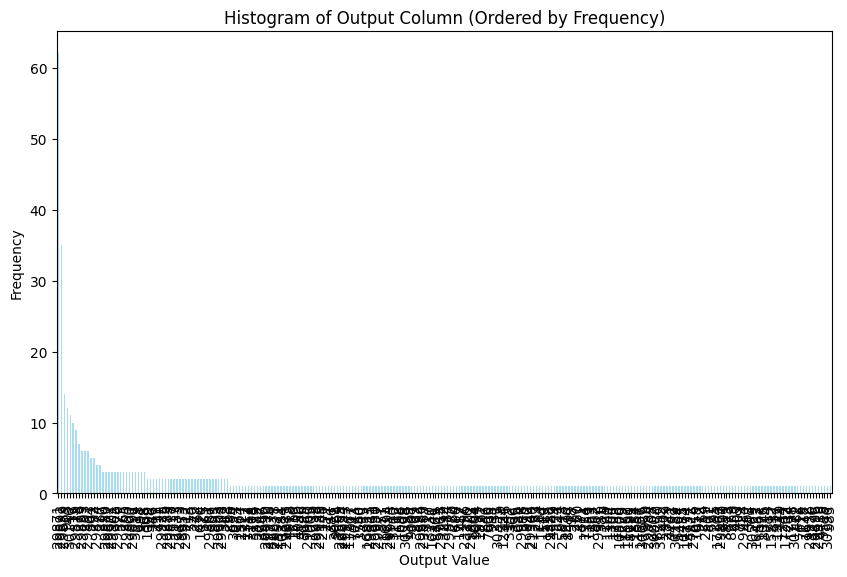

In [150]:
import matplotlib.pyplot as plt

histogram = df['output'].value_counts()

# Sort the histogram in descending order of frequency
histogram = histogram.sort_values(ascending=False)

# Create the histogram plot with specified color and alpha
plt.figure(figsize=(10, 6))
histogram.plot(kind='bar', color='skyblue', alpha=0.7)
plt.xlabel('Output Value')
plt.ylabel('Frequency')
plt.title('Histogram of Output Column (Ordered by Frequency)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility if needed
plt.show()

In [186]:
#random floats?
random_int = random.randint(1,512)
idx = [random.randint(0,32_000-1) for i in range(random_int)]
random_tensor = torch.FloatTensor(1,random_int,32_000).to(torch.float16).to(device)
#random_tensor[0, 0, idx] = 1.0

model_output = generator.model.forward(random_tensor,0)
last_token_logits = model_output[:,-1,:]
print(random_int, torch.argmax(last_token_logits,dim=-1))
#all 395, some zeeros
random_tensor #ahh!

414 tensor([0])


tensor([[[      inf,    0.0000, -628.5000,  ...,    0.0000,    0.0000,
             0.0000],
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
             0.0000],
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
             0.0000],
         ...,
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
             0.0000],
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
             0.0000],
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
             0.0000]]])

In [123]:
#2 per word? This is promising.  
random_int = random.randint(1,512)
lists = []
per_word = 2
for i in range(per_word):
    lists.append([random.randint(0,32_000-1) for i in range(random_int)])

random_tensor = torch.FloatTensor(1,random_int,32_000).to(torch.float16).to(device)

for k in lists:
    for i,j in enumerate(k):
        random_tensor[0,i, j] = 1

model_output = generator.model.forward(random_tensor,0)
last_token_logits = model_output[:,-1,:]
print(random_int, torch.argmax(last_token_logits,dim=-1))

408 tensor([4345])


In [143]:
random_int = random.randint(1,512)
lists = []
per_word = 10
for i in range(per_word):
    lists.append([random.randint(0,32_000-1) for i in range(random_int)])

random_tensor = torch.FloatTensor(1,random_int,32_000).to(torch.float16).to(device)

for k in lists:
    for i,j in enumerate(k):
        random_tensor[0,i, j] = 1

model_output = generator.model.forward(random_tensor,0)
last_token_logits = model_output[:,-1,:]
print(random_int, torch.argmax(last_token_logits,dim=-1))

159 tensor([0])


In [144]:
random_tensor has way unexpected values: what the

tensor([[[      inf,    0.0000, -628.5000,  ...,    0.0000,    0.0000,
             0.0000],
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
             0.0000],
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
             0.0000],
         ...,
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
             0.0000],
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
             0.0000],
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
             0.0000]]])

In [155]:
import random

random_int = random.randint(1,512)
random_tensor = torch.zeros(1, random_int, 32_000).to(torch.float16).to(device)

probability = 0.5

random_mask = torch.rand(random_tensor.shape)

random_tensor[random_mask < probability] = 1


print(random_tensor.dtype)
print(random_tensor)
model_output = generator.model.forward(random_tensor,0)
last_token_logits = model_output[:,-1,:]
print(random_int, torch.argmax(last_token_logits,dim=-1).item(),last_token_logits[0][:50].tolist())

torch.float16
tensor([[[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 1., 0.,  ..., 0., 1., 0.],
         [1., 0., 1.,  ..., 1., 0., 1.],
         ...,
         [1., 1., 1.,  ..., 0., 1., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]])
463 9152 [-0.51953125, 3.99609375, 0.505859375, -1.0927734375, 1.2294921875, 3.33984375, 0.0955810546875, -0.430908203125, 1.9306640625, 2.8359375, 3.998046875, 0.67724609375, 3.369140625, 1.41015625, -0.6865234375, -2.955078125, -0.517578125, -1.716796875, -1.8076171875, -0.0494384765625, -1.732421875, -0.67431640625, -2.443359375, 0.371337890625, -1.6005859375, -0.089599609375, -1.3525390625, -2.2734375, -2.064453125, -1.09375, -0.437255859375, -2.84765625, -1.3525390625, -0.343505859375, -0.4541015625, -0.51611328125, -0.51806640625, -0.51806640625, -0.51953125, -0.5185546875, -0.5166015625, -0.517578125, -0.51708984375, -0.517578125, -0.51708984375, -0.5166015625, -0.51708984375, -0.51708984375, -0.517578125, -

In [156]:
data_2 = [] #this is with half ones.   randomly. 
for i in range(500):
    random_int = random.randint(1,512)
    random_tensor = torch.zeros(1, random_int, 32_000).to(torch.float16).to(device)

    probability = 0.5

    random_mask = torch.rand(random_tensor.shape)

    random_tensor[random_mask < probability] = 1
    
    #print(random_tensor.dtype)
    #print(random_tensor)
    model_output = generator.model.forward(random_tensor,0)
    last_token_logits = model_output[:,-1,:]
    #print(random_int, torch.argmax(last_token_logits,dim=-1).item(),last_token_logits[0][:50].tolist())
    new_row = {'length': random_int, 'output': torch.argmax(last_token_logits,dim=-1).item(), 'first_fifty': last_token_logits[0][:50].tolist()}
    data_2.append(new_row)

In [157]:
df = pd.DataFrame(data_2)
df.head()

,length,output,first_fifty
0,317,9152,"[-0.457763671875, 4.27734375, 0.517578125, -1...."
1,285,9152,"[-0.42529296875, 4.25390625, 0.556640625, -1.0..."
2,346,9152,"[-0.4794921875, 4.23828125, 0.41162109375, -0...."
3,212,9152,"[-0.417724609375, 4.3125, 0.5146484375, -1.041..."
4,348,9152,"[-0.42529296875, 4.39453125, 0.4033203125, -0...."


In [158]:
df.to_csv("random_half_ones_input.csv")

In [160]:
output_counts = df['output'].value_counts()
print(output_counts)

output
9152     484
18518     15
3478       1
Name: count, dtype: int64


In [ ]:
BEHOLD! the issue.  

In [ ]:
Theory one....maybe we can reduce the numbers a lot and get some signal?


In [217]:
random_int = random.randint(1,512)
random_tensor = torch.FloatTensor(1, random_int,32_000 ).uniform_(0,1).to(torch.float16).to(device)
random_tensor = random_tensor/1_000_000
model_output = generator.model.forward(random_tensor,0)
last_token_logits = model_output[:,-1,:]
print(random_int, torch.argmax(last_token_logits,dim=-1))
#random_tensor/10 gave 27064, like, no exceptions
#random_tensor/100 showing 29949, same, no deviation
#random_tensor/1000 showing 29889, same, no deviation
#10_000 is 23196, so is 100_000, and one million.   

random_tensor

502 tensor([23196])


tensor([[[1.1921e-07, 5.9605e-08, 5.9605e-07,  ..., 2.3842e-07,
          9.5367e-07, 4.7684e-07],
         [7.7486e-07, 7.1526e-07, 1.7881e-07,  ..., 5.3644e-07,
          5.9605e-07, 9.5367e-07],
         [1.1921e-07, 2.9802e-07, 0.0000e+00,  ..., 4.1723e-07,
          8.9407e-07, 4.7684e-07],
         ...,
         [4.1723e-07, 4.7684e-07, 1.7881e-07,  ..., 1.1921e-07,
          2.9802e-07, 9.5367e-07],
         [5.9605e-07, 8.3447e-07, 5.3644e-07,  ..., 9.5367e-07,
          2.3842e-07, 0.0000e+00],
         [5.3644e-07, 4.7684e-07, 1.1921e-07,  ..., 4.7684e-07,
          5.3644e-07, 7.7486e-07]]])

In [28]:
data_2 = [] #this is with half ones.   randomly. 
for i in range(500):
    random_int = random.randint(1,512)
    random_tensor = torch.FloatTensor(1, random_int,32_000 ).uniform_(-10,10).to(torch.float16).to(device)
    model_output = generator.model.forward(random_tensor,0)
    last_token_logits = model_output[:,-1,:]
    print(random_int, torch.argmax(last_token_logits,dim=-1))
    #this slapppssss
    new_row = {'length': random_int, 'output': torch.argmax(last_token_logits,dim=-1).item(), 'first_fifty': last_token_logits[0][:50].tolist()}
    data_2.append(new_row)

318 tensor([581])
395 tensor([13257])
390 tensor([26448])
383 tensor([15441])
401 tensor([30879])
246 tensor([7630])
71 tensor([22033])
238 tensor([28433])
422 tensor([20551])
273 tensor([30247])
375 tensor([25880])
115 tensor([31873])
427 tensor([6085])
405 tensor([1372])
54 tensor([3156])
312 tensor([21756])
219 tensor([1480])
103 tensor([6604])
454 tensor([4243])
79 tensor([1210])
214 tensor([11738])
483 tensor([19930])
225 tensor([21942])
218 tensor([15565])
511 tensor([13167])
171 tensor([2681])
403 tensor([29121])
324 tensor([20666])
266 tensor([747])
384 tensor([3091])
10 tensor([6550])
88 tensor([15898])
139 tensor([11680])
470 tensor([4942])
378 tensor([21084])
367 tensor([6465])
68 tensor([7008])
110 tensor([31198])
269 tensor([20237])
299 tensor([2963])
241 tensor([29514])
233 tensor([10349])
250 tensor([11990])
382 tensor([23190])
486 tensor([13345])
348 tensor([16722])
512 tensor([19129])
234 tensor([3901])
39 tensor([27868])
379 tensor([5789])
84 tensor([3222])
89 tensor(

306 tensor([484])
205 tensor([31147])
194 tensor([133])
457 tensor([7214])
452 tensor([24918])
5 tensor([4289])
487 tensor([2784])
145 tensor([4578])
440 tensor([9549])
449 tensor([4494])
445 tensor([608])
99 tensor([16337])
84 tensor([2064])
3 tensor([23587])
168 tensor([22480])
51 tensor([26477])
58 tensor([2207])
169 tensor([16546])
432 tensor([17663])
115 tensor([7941])
176 tensor([7801])
404 tensor([21808])
73 tensor([24157])
300 tensor([17572])
68 tensor([3612])
180 tensor([8939])
365 tensor([20144])
164 tensor([29533])
394 tensor([24433])
471 tensor([31394])
257 tensor([24576])
447 tensor([856])
157 tensor([3690])
70 tensor([4578])
289 tensor([15695])
143 tensor([30879])
7 tensor([3658])
421 tensor([27918])
165 tensor([26827])
429 tensor([4877])
495 tensor([16118])
156 tensor([16473])
403 tensor([23996])
356 tensor([7955])
347 tensor([9890])
265 tensor([5842])
381 tensor([26782])
353 tensor([3538])
348 tensor([30811])
342 tensor([20421])
87 tensor([6994])
251 tensor([18703])
363

In [30]:

df = pd.DataFrame(data_2)
df.head()

,length,output,first_fifty
0,318,581,"[-0.417236328125, -3.861328125, -1.693359375, ..."
1,395,13257,"[-0.42626953125, -2.30859375, 0.247314453125, ..."
2,390,26448,"[-1.623046875, -0.732421875, 2.150390625, -0.1..."
3,383,15441,"[0.403564453125, -2.341796875, -3.9921875, 0.4..."
4,401,30879,"[-0.6552734375, -0.255126953125, 0.5947265625,..."


In [31]:
df
df.to_csv("random_-10_to_10_floats_input.csv")

In [32]:
df['output'].value_counts() #promising.   

output
30879    4
4578     3
30488    3
27918    2
2918     2
        ..
1358     1
149      1
9085     1
996      1
2571     1
Name: count, Length: 482, dtype: int64

In [ ]:
i need to think of how to visualize the fifty list.  could i make some kind of 2d histogram? 
like, i need values and spread.  or is that just 2 histograms.  one is values, one is standard deviations?  that isn't a bad idea


In [34]:
df['first_fifty']

0      [-0.417236328125, -3.861328125, -1.693359375, ...
1      [-0.42626953125, -2.30859375, 0.247314453125, ...
2      [-1.623046875, -0.732421875, 2.150390625, -0.1...
3      [0.403564453125, -2.341796875, -3.9921875, 0.4...
4      [-0.6552734375, -0.255126953125, 0.5947265625,...
                             ...                        
495    [-0.4521484375, 1.3544921875, 2.431640625, 1.8...
496    [0.6220703125, 3.884765625, 0.9609375, -0.6713...
497    [-0.58984375, 0.05560302734375, 1.79296875, -2...
498    [0.33984375, -0.2352294921875, -0.116149902343...
499    [-1.8798828125, -6.0234375, 1.234375, 1.776367...
Name: first_fifty, Length: 500, dtype: object

In [31]:
#okay, is it just the balanced range? 
data_2 = [] #this is with half ones.   randomly. 
for i in range(500):
    random_int = random.randint(1,512)
    random_tensor = torch.FloatTensor(1, random_int,32_000 ).uniform_(-50,50).to(torch.float16).to(device)
    model_output = generator.model.forward(random_tensor,0)
    last_token_logits = model_output[:,-1,:]
    print(random_int, torch.argmax(last_token_logits,dim=-1))
    #this slapppssss
    new_row = {'length': random_int, 'output': torch.argmax(last_token_logits,dim=-1).item(), 'first_fifty': last_token_logits[0][:50].tolist()}
    data_2.append(new_row)

109 tensor([21515])
386 tensor([30058])
307 tensor([16153])
202 tensor([23434])
89 tensor([27171])
14 tensor([6541])
113 tensor([4048])
152 tensor([14975])
429 tensor([23512])
286 tensor([9438])
353 tensor([8553])
412 tensor([23702])
282 tensor([16912])
189 tensor([5676])
340 tensor([14048])
174 tensor([5059])
331 tensor([9784])
79 tensor([31840])
69 tensor([11795])
116 tensor([1358])
235 tensor([3915])
85 tensor([23867])
368 tensor([708])
303 tensor([24700])
166 tensor([18128])
189 tensor([22220])
12 tensor([12195])
489 tensor([1227])
418 tensor([9940])
296 tensor([28857])
194 tensor([16323])
355 tensor([30997])
348 tensor([18083])
392 tensor([5031])
484 tensor([2893])
338 tensor([10533])
193 tensor([816])
334 tensor([30474])
258 tensor([1601])
281 tensor([16055])
257 tensor([17125])
234 tensor([8639])
238 tensor([3083])
121 tensor([31494])
508 tensor([19776])
133 tensor([9654])
259 tensor([14011])
303 tensor([15698])
151 tensor([26235])
435 tensor([15512])
419 tensor([9693])
122 tens

102 tensor([20288])
252 tensor([17510])
286 tensor([9029])
413 tensor([28051])
107 tensor([19628])
12 tensor([22642])
286 tensor([14201])
142 tensor([19619])
389 tensor([8226])
400 tensor([14977])
69 tensor([23670])
12 tensor([1233])
482 tensor([10785])
101 tensor([19483])
89 tensor([3547])
288 tensor([17652])
377 tensor([14503])
431 tensor([3871])
208 tensor([19286])
89 tensor([5708])
110 tensor([20716])
244 tensor([20772])
282 tensor([1])
472 tensor([15831])
282 tensor([1376])
330 tensor([30227])
249 tensor([12910])
129 tensor([2386])
96 tensor([28752])
307 tensor([8353])
242 tensor([8044])
258 tensor([10007])
239 tensor([27738])
262 tensor([3107])
166 tensor([12945])
199 tensor([2747])
81 tensor([15357])
114 tensor([9896])
93 tensor([5200])
118 tensor([5077])
168 tensor([4675])
277 tensor([5173])
438 tensor([15232])
281 tensor([10650])
133 tensor([12427])
317 tensor([1314])
399 tensor([25145])
126 tensor([6566])
309 tensor([631])
153 tensor([21261])
105 tensor([9335])
118 tensor([11

In [32]:
import pandas as pd
df = pd.DataFrame(data_2)
df.head()

,length,output,first_fifty
0,109,21515,"[-0.044677734375, -2.005859375, 1.193359375, 1..."
1,386,30058,"[0.244384765625, -3.947265625, -1.400390625, 1..."
2,307,16153,"[1.06640625, 1.7177734375, -0.85400390625, 0.9..."
3,202,23434,"[1.4404296875, 0.304931640625, -2.666015625, 2..."
4,89,27171,"[2.05859375, 0.5810546875, -1.7138671875, -3.0..."


In [33]:
df['output'].value_counts() # 121 distinct, 272 zeros.   that seems like, a waste of signal? not sure this was -1,1
# for -2,2: 215 distinct, 218 zeros
# for -5,5 435 distinct, 30488 had 24.  
# what about 20.  what are the duplicates? -20,20 477 distinct, 27918 had 5.  
#50? 477 distinct, 1 had 3.  

output
1        3
27918    3
3398     3
16153    2
8226     2
        ..
24642    1
4793     1
17179    1
30740    1
15702    1
Name: count, Length: 477, dtype: int64

In [ ]:
i want the standard deviations for the 50 first words.  thats next time

In [ ]:
i think -10,10 is giving me gradient issues.  at least in memorybaby